_This NP is developed and in use for experiments with pydap by forman (25.08.2022).
please do not change it without a PR or better create a copy._

---

**Important note:** The pydap API objects *are not serializable*. 
Hence it seems not possible to use Dask in distributed mode.

In [1]:
import dask
dask.config.set(scheduler='threads')

# Fails later:
# dask.config.set(scheduler='processes')

# Fails later:
# from distributed import Cluster()
# client = Cluster()

In [2]:
import json

# needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
import pydap.client 
import pydap.cas.get_cookies

Following code is borrowed from https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python.

But note, we do not use the `xr.backends.PydapDataStore` as in the example.

In [3]:
def open_copernicus_marine_pydap_dataset(dataset_id, username, password):
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = pydap.cas.get_cookies.setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    open_url_kwargs = dict(
        session=session,
        user_charset='utf-8', # CMEMS-specific
        output_grid=False     # retrieve only main arrays and never retrieve coordinate axes
    )
    try:
        url = f'https://my.cmems-du.eu/thredds/dodsC/{dataset_id}'
        pyd_dataset = pydap.client.open_url(url, **open_url_kwargs) 
    except:
        url = f'https://nrt.cmems-du.eu/thredds/dodsC/{dataset_id}'
        pyd_dataset = pydap.client.open_url(url, **open_url_kwargs) 
    return url, pyd_dataset

In [4]:
dataset_id = "dataset-bal-analysis-forecast-wav-hourly"

with open("cmems-credentials.json") as fp:
    credentials = json.load(fp)
    username, password = credentials["username"], credentials["password"]

In [5]:
url, pyd_dataset = open_copernicus_marine_pydap_dataset(dataset_id, username, password)

In [6]:
url

'https://nrt.cmems-du.eu/thredds/dodsC/dataset-bal-analysis-forecast-wav-hourly'

Let's inspect the returned pydap dataset.
See also https://www.pydap.org/en/latest/client.html#accessing-gridded-data!

In [7]:
pyd_dataset

<DatasetType with children 'lat', 'lon', 'time', 'VHM0', 'VTPK', 'VTM10', 'VTM02', 'VMDR', 'VHM0_WW', 'VTM01_WW', 'VMDR_WW', 'VPED', 'VHM0_SW1', 'VTM01_SW1', 'VMDR_SW1', 'VHM0_SW2', 'VTM01_SW2', 'VMDR_SW2', 'VSDX', 'VSDY'>

In [8]:
pyd_dataset.attributes

{'NC_GLOBAL': {'Conventions': 'CF-1.0',
  'source': 'FMI-WAM_CMEMS',
  'institution': 'Baltic MFC, PU Finnish Meteorological Institute',
  'title': 'CMEMS WAM model fields (hourly)',
  'cmems_product_id': 'BALTICSEA_ANALYSISFORECAST_WAV_003_010',
  'westernmost_longitude': '9.0138',
  'easternmost_longitude': '30.2080',
  'southernmost_latitude': '53.0083',
  'northernmost_latitude': '65.9081',
  'grid_resolution': '1 nautical mile (ie. 0.0167 degrees northward; 0.0278 degrees eastward'},
 'DODS_EXTRA': {}}

In [9]:
global_attrs = dict(pyd_dataset.attributes.get('NC_GLOBAL') or {})
global_attrs["dataset_url"] = url

In [10]:
pyd_dataset.lat

<BaseType with data BaseProxy('https://nrt.cmems-du.eu/thredds/dodsC/dataset-bal-analysis-forecast-wav-hourly', 'lat', dtype('>f4'), (775,), (slice(None, None, None),))>

In [11]:
pyd_dataset.lon[0:10]

<BaseType with data array([9.013887 , 9.041664 , 9.069442 , 9.0972185, 9.124995 , 9.152772 ,
       9.18055  , 9.208326 , 9.236103 , 9.263881 ], dtype=float32)>

In [12]:
pyd_dataset.lat[0:10]

<BaseType with data array([53.00829 , 53.024956, 53.041622, 53.05829 , 53.074955, 53.091618,
       53.108284, 53.12495 , 53.141617, 53.158283], dtype=float32)>

In [13]:
pyd_dataset.time.attributes

{'standard_name': 'time',
 'long_name': 'time',
 'units': 'seconds since 1970-01-01 00:00:00',
 'calendar': 'standard',
 '_ChunkSizes': 1024}

In [14]:
pyd_dataset.time[0:10]

<BaseType with data array([1.5436260e+09, 1.5436296e+09, 1.5436332e+09, 1.5436368e+09,
       1.5436404e+09, 1.5436440e+09, 1.5436476e+09, 1.5436512e+09,
       1.5436548e+09, 1.5436584e+09])>

In [15]:
# This will lead to error "ValueError: buffer size must be a multiple of element size"
# pyd_dataset.VMDR[100, 300:310, 400:410]

In [16]:
pyd_dataset.VMDR.array[100, 300:310, 400:410]

<BaseType with data array([[[288.4607 , 287.9629 , 287.48666, 287.14572, 286.95096,
         286.83032, 286.69336, 286.45355, 286.07428, 285.66483],
        [287.7408 , 287.30734, 286.90234, 286.57925, 286.3968 ,
         286.31995, 286.24457, 286.14514, 285.93735, 285.63608],
        [287.04715, 286.70847, 286.34885, 285.9923 , 285.80377,
         285.74606, 285.71646, 285.67203, 285.55933, 285.33994],
        [286.47977, 286.2102 , 285.9278 , 285.59164, 285.406  ,
         285.34613, 285.3402 , 285.33102, 285.29425, 285.14996],
        [285.98584, 285.79605, 285.61185, 285.3545 , 285.19272,
         285.16455, 285.20557, 285.2506 , 285.24893, 285.14148],
        [285.5887 , 285.49182, 285.4014 , 285.2549 , 285.10303,
         285.0756 , 285.1475 , 285.23065, 285.2389 , 285.16354],
        [285.2081 , 285.19907, 285.1952 , 285.09195, 284.92102,
         284.864  , 284.9512 , 285.06113, 285.09802, 285.05173],
        [284.84332, 284.87265, 284.91058, 284.80957, 284.65436,
         284.

---

Test as xarray backend first:

In [17]:
import xarray as xr 

# xr_dataset = xr.open_dataset(xr.backends.PydapDataStore(pyd_dataset))
# xr_dataset

# It doesn't work - we get 
#
# Error {
#    code = 403;
#    message = "Request too big=77929.8336 Mbytes, max=1500.0";
# };

In [18]:
# xr_dataset.VHM0

In [19]:
# xr_dataset.VHM0[0].plot()

---

We now know enough to setup our own Zarr store:

In [20]:
from typing import List

import numpy as np
import xarray as xr
import zarr

from xcube.core.zarrstore import GenericZarrStore

In [21]:

def get_data(chunk_index, pyd_var=None, chunk_info=None, array_info=None):
    array_name = array_info["name"]        
    array_slices = chunk_info["slices"]        
    display(f"Fetching {array_name} for chunk {chunk_index} at {array_slices}")

    # Actual pydap data access
    if hasattr(pyd_var, "array"):
        data = pyd_var.array[array_slices]
    else:
        data = pyd_var[array_slices]
    return np.array(data)


def get_generic_arrays(pyd_dataset) -> List[GenericZarrStore.Array]:
    """Get the list of generic arrays from the list of pydap 
    variables in *pyd_dataset*.
    """
    arrays = []
    for name, pyd_var in pyd_dataset.items():
        attrs = dict(pyd_var.attributes)
        # Note, it seems that there is no advantage in using the 
        # _ChunkSizes which come from original NetCDF files.
        # Users should specify the desired chunksizes on their own.
        # For example, coordinate arrays should not be chunked at all!
        chunks = attrs.pop("_ChunkSizes", None)
        chunks = (chunks,) if isinstance(chunks, int) else \
            tuple(chunks) if chunks is not None else None
        fill_value = attrs.pop("_FillValue", None)
        array = GenericZarrStore.Array(
            name=name,
            dtype=pyd_var.dtype.str,
            dims=pyd_var.dimensions,
            shape=pyd_var.shape,
            chunks=chunks,
            fill_value=fill_value,
            get_data=get_data,
            get_data_params=dict(pyd_var=pyd_var),
            attrs=attrs,
            compressor=None,
            chunk_encoding="ndarray",
        )
        arrays.append(array)
    return arrays


In [22]:
arrays = get_generic_arrays(pyd_dataset)

# Uncomment to see the effect of chunked time --> many slow requests
for array in arrays:
    if array["name"] == "time":
        del array["chunks"]

In [23]:
zarr_store = GenericZarrStore(*arrays, attrs=global_attrs)

Because the arrays of `GenericZarrStore` are really generic and do not cache any data, 
we wrap it into a LRU cache to avoid fetching coordinate arrays and the like multiple times.

In [24]:
zarr_store = zarr.LRUStoreCache(zarr_store, max_size=2**28)

In [25]:
xr_dataset = xr.open_zarr(zarr_store)
xr_dataset

'Fetching time for chunk (0,) at (slice(0, 32952, None),)'

'Fetching lat for chunk (0,) at (slice(0, 775, None),)'

'Fetching lon for chunk (0,) at (slice(0, 764, None),)'

<xarray.Dataset>
Dimensions:    (time: 32952, lat: 775, lon: 764)
Coordinates:
  * lat        (lat) float32 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89 65.91
  * lon        (lon) float32 9.014 9.042 9.069 9.097 ... 30.12 30.15 30.18 30.21
  * time       (time) datetime64[ns] 2018-12-01T01:00:00 ... 2022-09-04
Data variables: (12/17)
    VHM0       (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VHM0_SW1   (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VHM0_SW2   (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VHM0_WW    (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VMDR       (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VMDR_SW1   (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    ...         ...
    VTM01_SW1  (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VTM01_SW2  (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VTM01_WW   (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VTM02      (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VTM10      (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
    VTPK       (time, lat, lon) float32 dask.array<chunksize=(4, 481, 474), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.0
    source:                 FMI-WAM_CMEMS
    institution:            Baltic MFC, PU Finnish Meteorological Institute
    title:                  CMEMS WAM model fields (hourly)
    cmems_product_id:       BALTICSEA_ANALYSISFORECAST_WAV_003_010
    westernmost_longitude:  9.0138
    easternmost_longitude:  30.2080
    southernmost_latitude:  53.0083
    northernmost_latitude:  65.9081
    grid_resolution:        1 nautical mile (ie. 0.0167 degrees northward; 0....
    dataset_url:            https://nrt.cmems-du.eu/thredds/dodsC/dataset-bal...

In [26]:
xr_dataset.VHM0

<xarray.DataArray 'VHM0' (time: 32952, lat: 775, lon: 764)>
dask.array<open_dataset-8f43caa02747a376204bb32db4e2feeaVHM0, shape=(32952, 775, 764), dtype=float32, chunksize=(4, 481, 474), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89 65.91
  * lon      (lon) float32 9.014 9.042 9.069 9.097 ... 30.12 30.15 30.18 30.21
  * time     (time) datetime64[ns] 2018-12-01T01:00:00 ... 2022-09-04
Attributes:
    long_name:      Spectral significant wave height (Hm0)
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_min:      0.0
    valid_max:      20.0

'Fetching VHM0 for chunk (0, 0, 0) at (slice(0, 4, None), slice(0, 481, None), slice(0, 474, None))'

'Fetching VHM0 for chunk (0, 1, 0) at (slice(0, 4, None), slice(481, 775, None), slice(0, 474, None))'

'Fetching VHM0 for chunk (0, 1, 1) at (slice(0, 4, None), slice(481, 775, None), slice(474, 764, None))'

'Fetching VHM0 for chunk (0, 0, 1) at (slice(0, 4, None), slice(0, 481, None), slice(474, 764, None))'

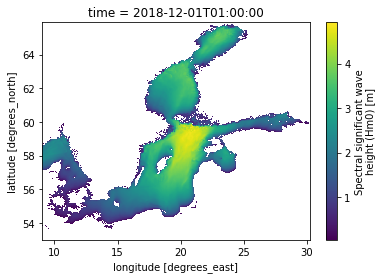

In [27]:
xr_dataset.VHM0[0].plot()

In [31]:
vhm0_daily_mean = xr_dataset.VHM0.resample(time="1D").mean()

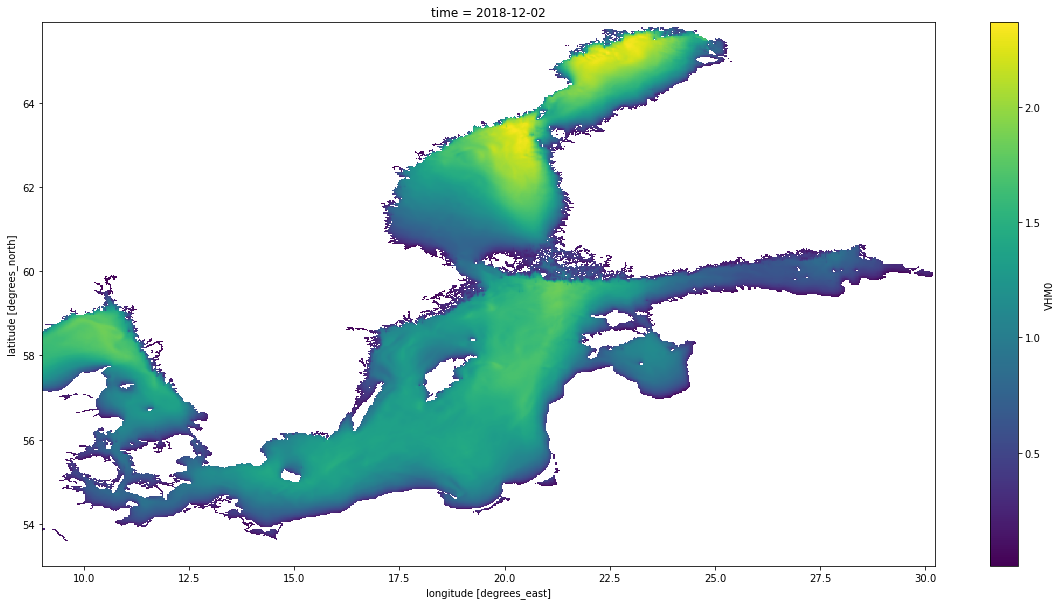

In [34]:
vhm0_daily_mean.isel(time=1).plot(figsize=(20, 10))

---

Check out
* https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap
* https://docs.opendap.org/index.php?title=DAP4_Specification
* https://pythondig.com/r/arrdap-is-a-fastapi-project-that-provides-access-to-zarr-and-netcdf-data-in-remote-object-storage-using-the-opensource-project-for-a-network-data-acc

<xarray.DataArray 'time' (time: 32952)>
array(['2018-12-01T01:00:00.000000000', '2018-12-01T02:00:00.000000000',
       '2018-12-01T03:00:00.000000000', ..., '2022-09-03T22:00:00.000000000',
       '2022-09-03T23:00:00.000000000', '2022-09-04T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-12-01T01:00:00 ... 2022-09-04
Attributes:
    standard_name:  time
    long_name:      time